In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pycomlink as pycml
from pycomlink.core import ComlinkChannel

f =  16

t_date_range = pd.date_range(start='2015-01-01', periods=200, freq='min')
t_list = [str(date) for date in t_date_range]
rx_list = list(np.sin(np.linspace(0, 10, len(t_list))))
tx_list = list(0.1 * np.cos(np.linspace(0, 100, len(t_list))))

df = pd.DataFrame(index=t_date_range, data={'rx': rx_list, 'tx': tx_list})
cml_ch_1min = ComlinkChannel(data=df, f_GHz=f)
cml_ch_1min_2 = ComlinkChannel(data=df*0.8, f_GHz=f)
cml_ch_1min_3 = ComlinkChannel(data=df*0.7, f_GHz=f)
cml_ch_5min = ComlinkChannel(data=df.resample('5min').apply(np.mean), f_GHz=f)

In [86]:
from pycomlink.core import Comlink

In [87]:
metadata = {'site_a_latitude': 48.1,
             'site_a_longitude': 11.1,
             'site_b_latitude': 48.2,
             'site_b_longitude': 11.0,
             'cml_id': 'abc123'}

cml = Comlink(channels=[cml_ch_1min, cml_ch_1min_2, cml_ch_1min_3], metadata=metadata)

In [88]:
cml

,rx,tx,txrx
time,,,
2015-01-01 00:00:00,0.000000,0.100000,0.100000
2015-01-01 00:01:00,0.050230,0.087638,0.037407
2015-01-01 00:02:00,0.100333,0.053607,-0.046727
2015-01-01 00:03:00,0.150183,0.006322,-0.143862
2015-01-01 00:04:00,0.199654,-0.042526,-0.242181
2015-01-01 00:05:00,0.248621,-0.080860,-0.329481
2015-01-01 00:06:00,0.296960,-0.099201,-0.396161
2015-01-01 00:07:00,0.344549,-0.093014,-0.437564
2015-01-01 00:08:00,0.391269,-0.063830,-0.455099


array([<matplotlib.axes._subplots.AxesSubplot object at 0x118458590>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x118715290>], dtype=object)

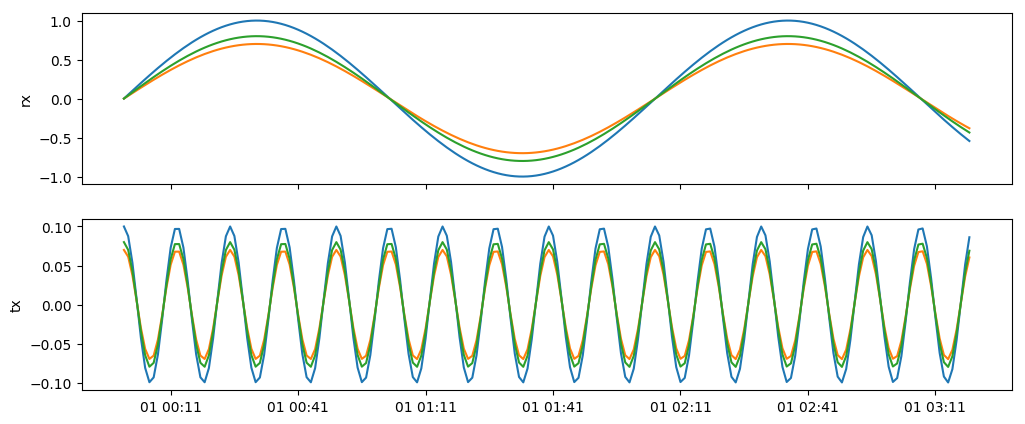

In [9]:
cml.plot_data(['rx', 'tx'])

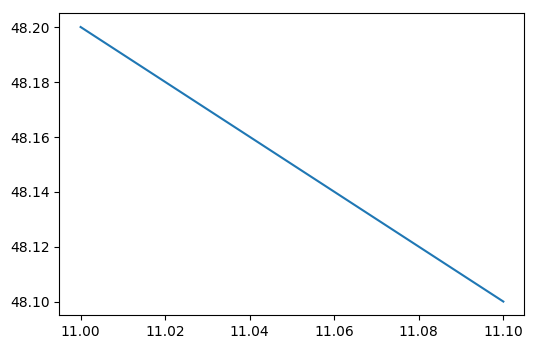

In [10]:
cml.plot_line()

In [11]:
cml.plot_map()

# Do processing using the `Processor` 

In [13]:
from pycomlink.processing import Processor

In [14]:
cmlp = Processor(cml)

In [15]:
cmlp.wet_dry.std_dev(10, 0.11)

/Users/chwala-c/code/pycomlink/pycomlink/processing/wet_dry/std_dev.py:83: RuntimeWarning: invalid value encountered in greater
  wet = roll_std_dev > threshold


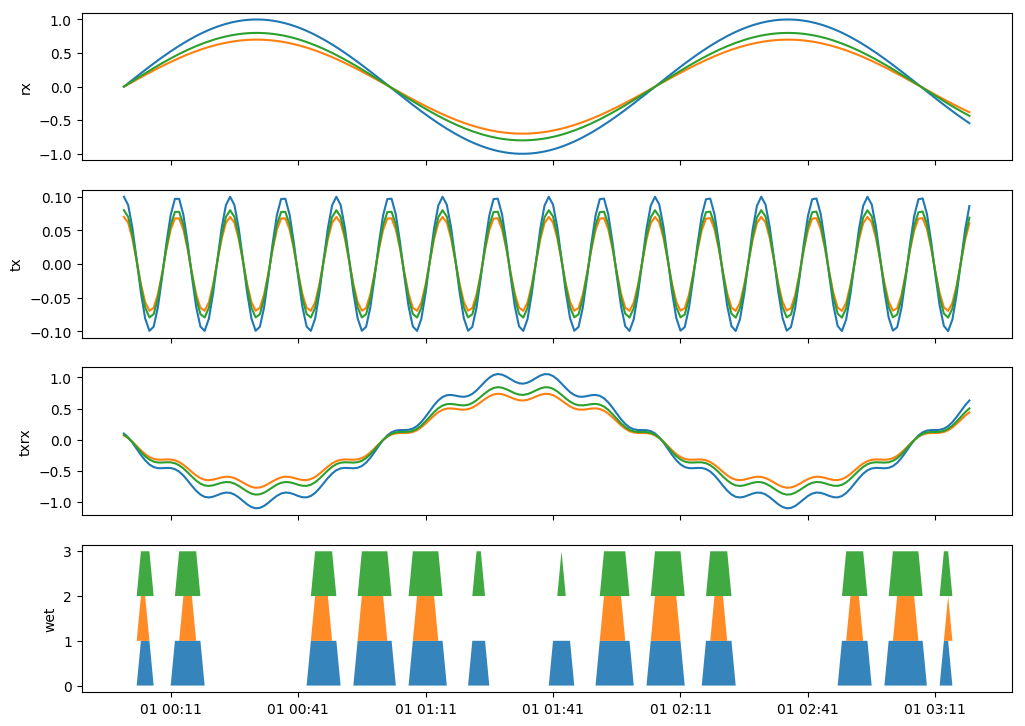

In [17]:
cmlp.cml.plot_data(['rx', 'tx', 'txrx', 'wet']);

In [18]:
cmlp.baseline.constant()
cmlp.baseline.calc_A()

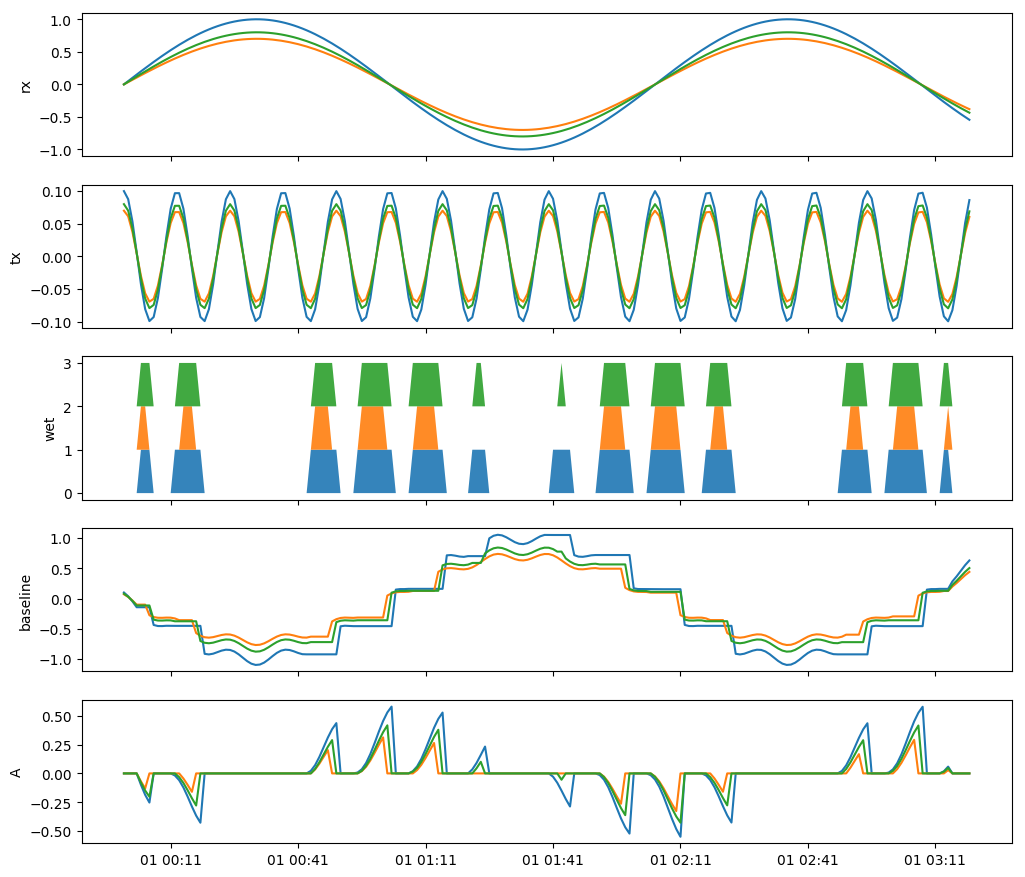

In [19]:
cmlp.cml.plot_data(['rx', 'tx', 'wet', 'baseline', 'A']);

In [20]:
cmlp.A_R.calc_R()

/Users/chwala-c/code/pycomlink/pycomlink/processing/A_R_relation/A_R_relation.py:41: RuntimeWarning: invalid value encountered in power
  R = (A/(a*L))**(1/b)


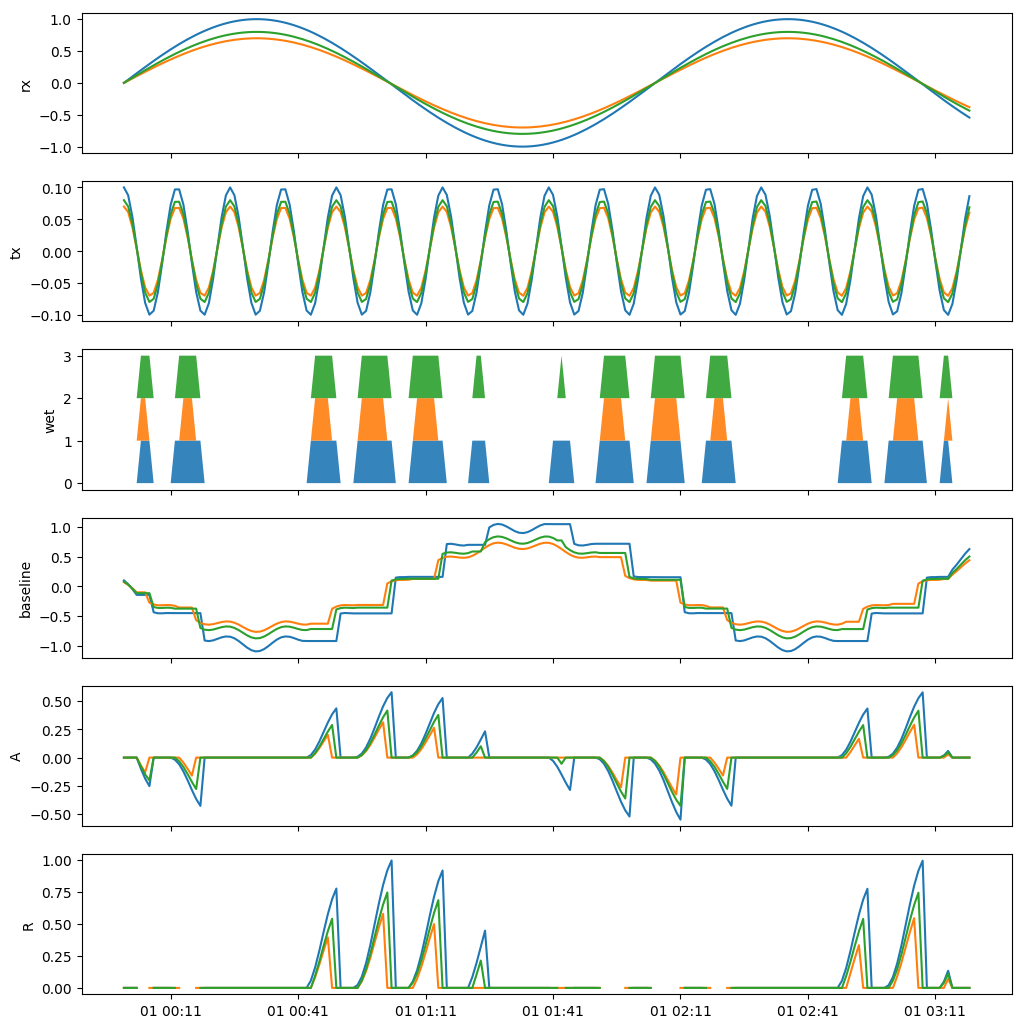

In [21]:
cmlp.cml.plot_data(['rx', 'tx', 'wet', 'baseline', 'A', 'R']);

# Do processing using the stand-alone processing functions 

In [23]:
cml = pycml.processing.wet_dry.std_dev.std_dev_classification(cml, window_length=10, threshold=0.11)

Could not find TRSL in channel. Using TX-RX or only RX.
Could not find TRSL in channel. Using TX-RX or only RX.
Could not find TRSL in channel. Using TX-RX or only RX.


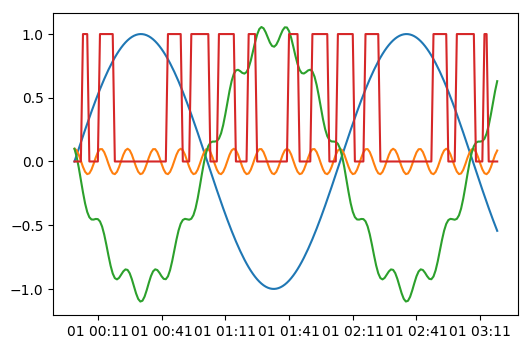

In [24]:
plt.plot(cml.channel_1)

In [31]:
baseline = pycml.processing.baseline.baseline.baseline_constant(cml.channel_1.rx, cml.channel_1.wet)

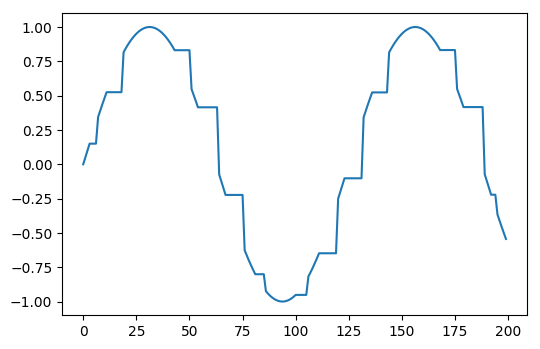

In [32]:
plt.plot(baseline)

In [34]:
ts_wet, roll_std_dev = pycml.processing.wet_dry.std_dev.std_dev_classification(cml.channel_1, window_length=10, threshold=0.11)

Could not find TRSL in channel. Using TX-RX or only RX.


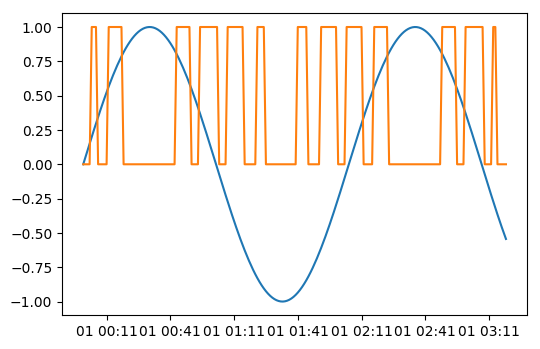

In [35]:
plt.plot(cml.channel_1.rx)
plt.plot(ts_wet)

# Timing for pandas operation *in_place* vs. *copy* 

In [36]:
import pandas as pd
import numpy as np

In [37]:
def update_inplace(df, key, factor):
    df[key] = df['test1'] * factor
    return df

def update_and_return_copy(df, key, factor):
    df_new = df.copy(deep=True)
    df_new[key] = df_new['test1'] * factor
    return df_new

In [73]:
df = pd.DataFrame(data={'test1': np.random.rand(1000000)})

In [74]:
df_updated_inplace = update_inplace(df, 'in_place', 5)

In [75]:
df_updated_inplace.head()

,test1,in_place
0,0.934028,4.670138
1,0.556907,2.784537
2,0.154781,0.773903
3,0.860594,4.302971
4,0.413954,2.069770


In [76]:
df.head()

,test1,in_place
0,0.934028,4.670138
1,0.556907,2.784537
2,0.154781,0.773903
3,0.860594,4.302971
4,0.413954,2.069770


In [77]:
df['test1'].ix[0] = -99999

In [78]:
df_updated_inplace.head()

,test1,in_place
0,-99999.000000,4.670138
1,0.556907,2.784537
2,0.154781,0.773903
3,0.860594,4.302971
4,0.413954,2.069770


In [79]:
df = pd.DataFrame(data={'test1': np.random.rand(10000000)})

In [80]:
df_updated_copy = update_and_return_copy(df, 'copied', 3)

In [81]:
df_updated_copy.head()

,test1,copied
0,0.203768,0.611304
1,0.163787,0.491362
2,0.886810,2.660429
3,0.341657,1.024971
4,0.803217,2.409652


In [82]:
df['test1'].ix[0] = -99999

In [83]:
df.head()

,test1
0,-99999.000000
1,0.163787
2,0.886810
3,0.341657
4,0.803217


In [84]:
df_updated_copy.head()

,test1,copied
0,0.203768,0.611304
1,0.163787,0.491362
2,0.886810,2.660429
3,0.341657,1.024971
4,0.803217,2.409652


In [48]:
%%timeit
df_updated_inplace = update_inplace(df, 'in_place', 5)

10 loops, best of 3: 70.3 ms per loop


In [49]:
%%timeit
df_updated_copy = update_and_return_copy(df, 'copied', 3)

The slowest run took 4.08 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 135 ms per loop


# Test for updating a dict in a list of dicts 

In [53]:
list_of_dicts = [{'foo': 111, 'bar': 1},
                 {'foo': 222, 'bar': 2}]

for d in list_of_dicts:
    if d['bar'] == 1:
        d['foo'] = 999
        d['baz'] = 'dafas'
list_of_dicts

[{'bar': 1, 'baz': 'dafas', 'foo': 999}, {'bar': 2, 'foo': 222}]

In [51]:
list_of_dicts = [{'foo': 111, 'bar': 1},
                 {'foo': 222, 'bar': 2}]

for d in list_of_dicts:
    if d['bar'] == 1:
        d = {'hans': 'dampf'}
list_of_dicts

[{'bar': 1, 'foo': 111}, {'bar': 2, 'foo': 222}]